Modelling an agent in 2d plane, with preferred state being the unit circle, with zero noise observation channel
---
We are attempting to model an AIF agent in a 2D plane, which has learnt the environment and now is performing EFE minimization to make decisions. This implementation is characterized by a standard **noisy state model with linear control** and exact correspondence between observations and states. The simpler observation model leads to zero weightage for state-observation ambiguity and the decisions are solved based on the KL divergence between the observations and the preferred observations distribution. The latter is defined in this implementation as a circle with radius R. The expected behaviour is the agent approaching this circle from its initial position and statying near it in the subsequent timesteps.

Making necessary imports

In [4]:
from jax import numpy as jnp
import numpy as np

Defining the dimensions of the problem and the state transition model, which is defined as : **s_t = As_t-1 + Bu_t-1 + b + noise**

With
>A: identity matrix

>b: [0,del_theta]

>B_u: [B,0]

>noise: 2d gaussian

Hence the parameters involeved in the state model are:
1) **del_theta**: how much rotation with each time step

2) **B**: How much radial displacement away/towards the origin with each chosen action

3) **noise scale**: variance of the white noise


In [5]:

Ds=2
Do=2
Du=1


#defining the state tranistion matrices: s_t = As_t-1 + Bu_t-1 + b + noise


A=jnp.eye(2)

# lets choose del_theta = 0.1 radians
del_theta=0.1
b=jnp.array([0,del_theta])

# choosing B_u as follows
B=1
B_u=jnp.array([B,0])

#assume noise to be a a gaussian of mean zero and defined variance
noise_scale=0.0001
noise_sigma=noise_scale*jnp.eye(2)

#NOTE: here the observation model is simply: o_t=s_t


XlaRuntimeError: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory

Here we define the prefered observations as a gaussian distribution with mean **[R,0]** (where R is the preferred radius) and covariance matrix **[[sig_1,0],[0,sig_2]]**, characterized by small sig_1 and large sig_2. This ensures that the distribution peaks at the R value and yet spreadsd across all theta values.

Here hence the paramaters involved are:

1) **R**: defined the preferred radial distance
2) **sig_1**: defines how sharp the distribution of r values are around the R value(smaller value preferred)
3) **sig_2**: defines how sharp the distribution of thera values are around 0(larger value preferred)

In [ ]:
#defining the preferred observations
R=5
sig_1=0.00000001
sig_2=7

mu_preferred = jnp.array([R,0])
sigma_preferred = jnp.array([[sig_1,0],[0,sig_2]])



p(a\b)*p(b\c)=p(a\b,c)

Defining the compute_G_next_step function that takes in the current state **s_t** and the chosen action **u_t** and computes the expected free energy in the next step which is the following KL divergence: **KL[q(o_t+1|u_t)||p(o|c)]**. It can be shown that the distribution of **q(o_t+1|u_t)** is the same as **p(s_t+1|s_t,u_t)**. The latter by definition has mean **As_t + Bu_t + b** and covariance that of the state model.
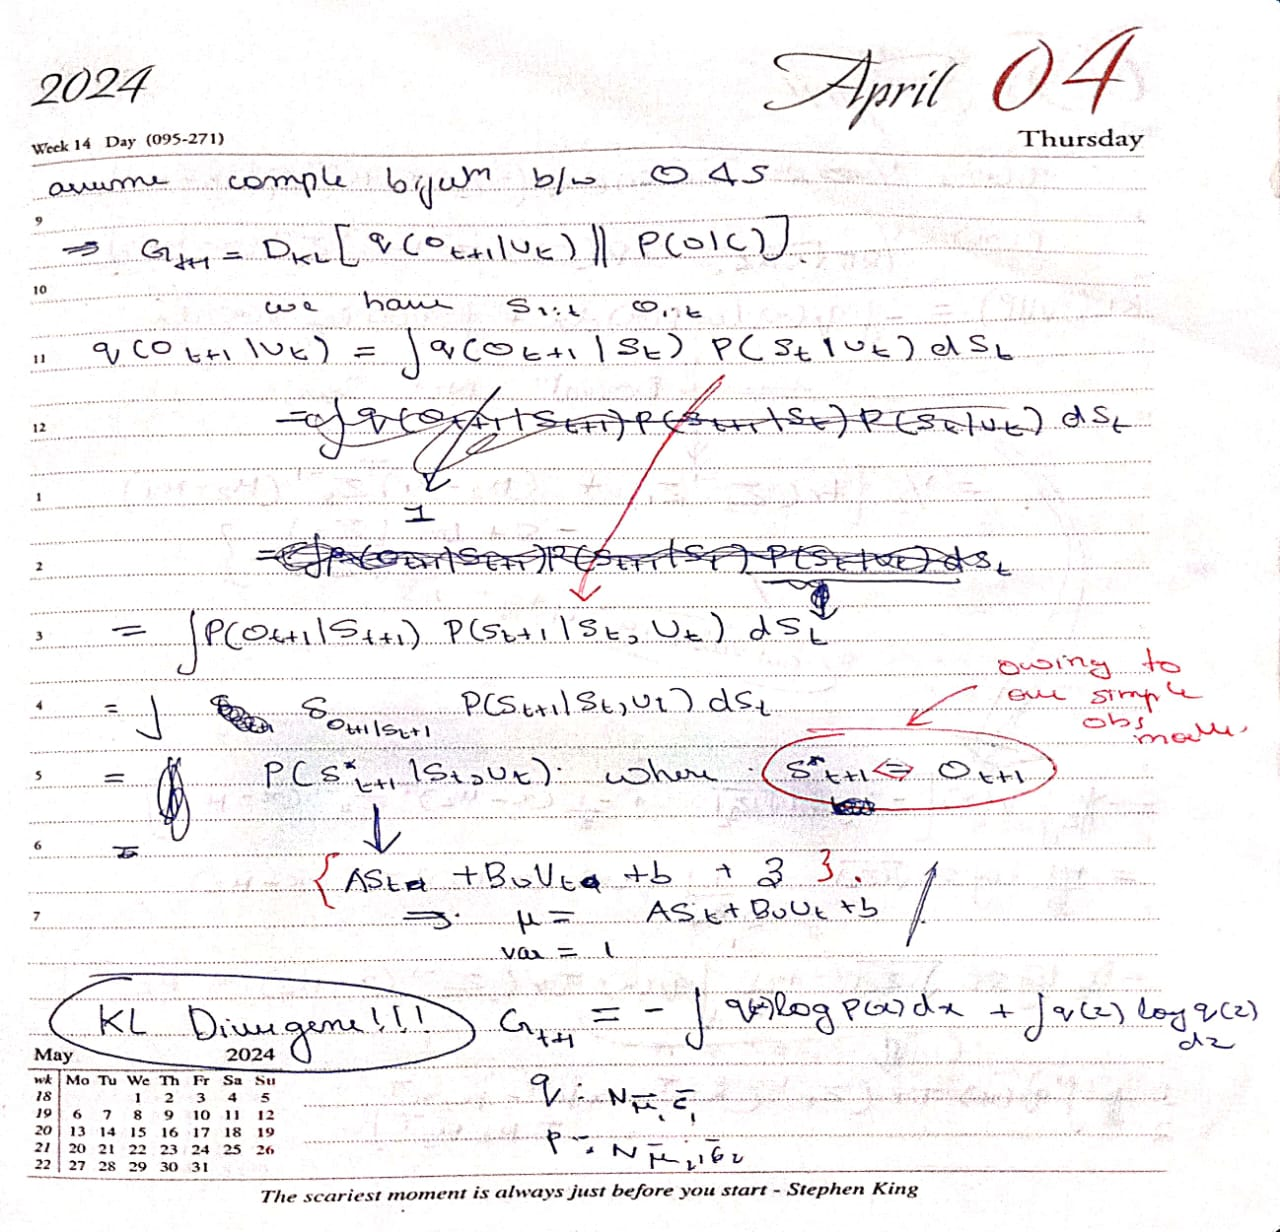

In [ ]:
#define a function to compute the expected free energy of the next step, given the expected action u_t
#need to be defined better, at this point only variable we are considering is u
def compute_G_next_step(u_t,s_t):
    ''' because of the simplicity of the observation model its just the KL divergence ----> KL[q(o_t+1|u_t)||p(o|c)]'''
    #for q , calculating mu and sigma
    mu=jnp.matmul(A,s_t) + u_t*B_u + b
    sigma = noise_sigma
    return compute_KL_div_gaussian(mu_preferred,sigma_preferred,mu,sigma)

    
    
    

Defining a function to compute the KL divergence between two gaussian distributions:

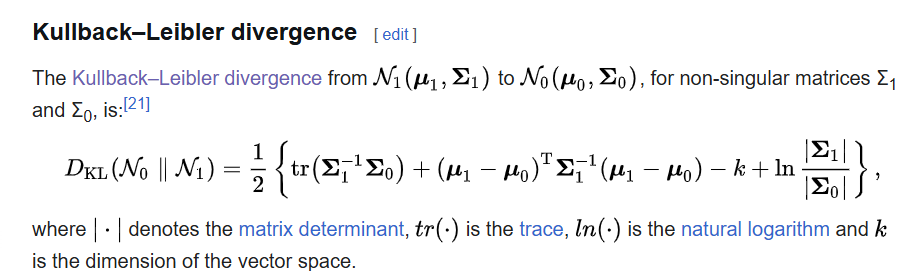

In [ ]:
def compute_KL_div_gaussian(mu_1,sigma_1,mu_2,sigma_2):
    print(np.shape(mu_1))
    print(np.shape(mu_2))
    print(np.shape(sigma_1))
    print(np.shape(sigma_2))
    print(np.shape(jnp.linalg.inv(sigma_2)))
    return 0.5*(jnp.log(jnp.linalg.det(sigma_2)/jnp.linalg.det(sigma_1)) - 2 + jnp.trace(jnp.matmul(jnp.linalg.inv(sigma_2),sigma_1)) + jnp.matmul((mu_1-mu_2).T,jnp.matmul(jnp.linalg.inv(sigma_2),(mu_1-mu_2))))
                
                

Trials
-------
checking the functions with respect to array shapes!!!

In [6]:
jnp.shape(jnp.matmul(A,jnp.array([9,0])))

NameError: name 'A' is not defined

In [ ]:
mu=jnp.array([1,1])
sigma=jnp.eye(2)
print(jnp.shape(jnp.matmul(A,s_t) + u_t*B_u + b))
compute_KL_div_gaussian(mu_preferred,sigma_preferred,mu,sigma)

Implementation I
----

This is the actual implementation of the agent behaviour using the funtions defiend before. We start with an initial state **s0**. At each time step the free energy is computed for the both choices of action and the action with least G is used in the state model to compute the transition to the new state. The ranges of the variables inolved(**R>0 and 0<=theta<=2pi**) are enforced. In the next time step, the procedure is repeated with the new state as the current state. 

Parameters involved:
1) **s0**: initial state
2) **num_steps**: length of the simulation

In [ ]:
s0=jnp.array([1,0])
state_list=[]
state_list.append(s0)
num_steps=100
for i in range(num_steps):
    print('iteration number:',i,'state :',state_list[-1])
    s_t=state_list[-1]
    if compute_G_next_step(jnp.array(+1),s_t) < compute_G_next_step(-1,s_t):
        u_t=+1
    else:
        u_t=-1
    new_state=jnp.matmul(A,s_t) + u_t*B_u + b + np.random.normal(0,noise_scale,size=(2))
    
    #ensuring that theta between 0 and 2 pi
    new_theta=new_state[1]%6.28
    
    #ensuring that r>0
    if new_state[0]<0:

        new_state=new_state.at[0].set(0)

        
    new_state=jnp.array([new_state[0],new_theta])
    state_list.append(new_state)

    
    

Plotting the results on XY space, with the colour gradation signifying the dynamics from cooler to warmer colours.

In [ ]:
import matplotlib.pyplot as plt


data = state_list  


r_values = [point[0] for point in data]
theta_values = [point[1] for point in data]


time_steps = range(len(data))
colors = plt.cm.plasma([t / max(time_steps) for t in time_steps])  # Cooler to warmer colors

# Plot in polar coordinates
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)



# Plot the lines connecting the points
ax.plot(theta_values, r_values, color='gray', alpha=0.5, linestyle='--', label="Trajectory")

# Plot the scatter points
scatter = ax.scatter(theta_values, r_values, c=time_steps, cmap='plasma', edgecolor='k', s=50)

# Add a colorbar to indicate time evolution
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Time Step', fontsize=12)

# Set plot title
ax.set_title('Time Evolution in Polar Coordinates', fontsize=14)
ax.legend(loc="upper left")

plt.show()
